In [50]:
%matplotlib inline
import matplotlib as mpl
print __doc__
import numpy as np
import pyart
import matplotlib.pyplot as plt
import netCDF4
import copy
import scipy.ndimage as nd
import numpy.ma as ma
from IPython.display import Latex
import sys
import corregir_azimuth
from corregir_azimuth import*

Automatically created module for IPython interactive environment


In [51]:
radar= pyart.io.read('/home/sofia/proyecto/Datos_test/NetCDF/cfrad.20100209_210344.000_to_20100209_210722.000_INTA_Ang_v127_SUR.nc')

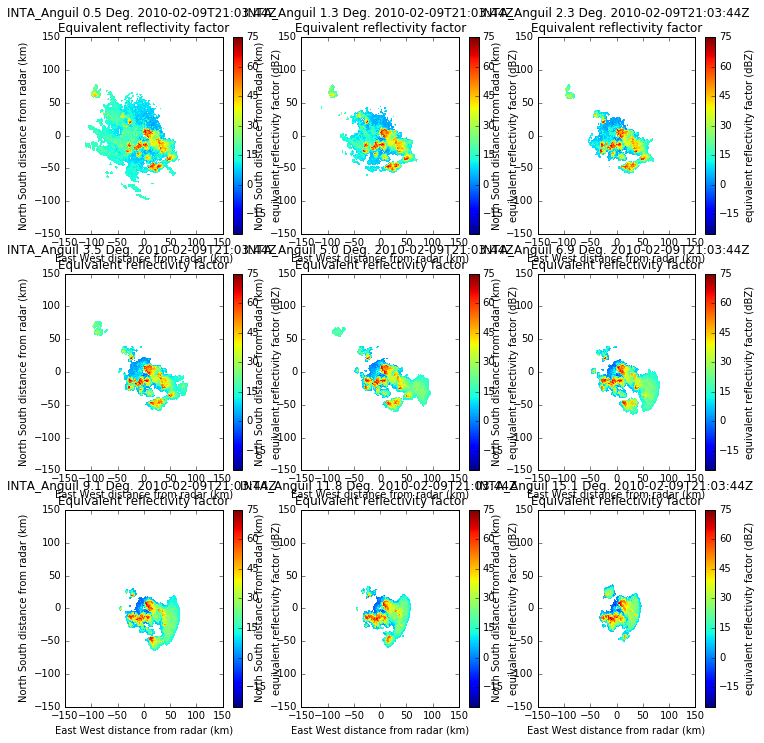

In [186]:
display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize = [12,12])

plt.subplot(3, 3, 1) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,cmap='jet')
plt.subplot(3, 3, 2) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=1,cmap='jet')
plt.subplot(3, 3, 3) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=2,cmap='jet')
plt.subplot(3, 3, 4) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=3,cmap='jet')
plt.subplot(3, 3, 5) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=4,cmap='jet')
plt.subplot(3, 3, 6) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=5,cmap='jet')
plt.subplot(3, 3, 7) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=6,cmap='jet')
plt.subplot(3, 3, 8) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=7,cmap='jet')
plt.subplot(3, 3, 9) 
display.plot_ppi('dBZ',vmin=-25,vmax=75,sweep=8,cmap='jet')



In [52]:
AzC=corregir_azimuth(radar)
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

d2r=np.pi/180 


### Proyección sobre la superficie

In [210]:
sweep=5
elevs=np.unique(radar.elevation['data'])
rango=radar.range['data']
az_s=radar.azimuth['data'][359*sweep:359*(sweep+1)]
#r=radar.extract_sweeps([sweep])
X = np.linspace(-120000.10, 120000.10, num=240) # en metros
Y = np.linspace(-120000.10,120000.10, num=240) # en metros
data=np.ones([len(X),len(Y)])
for i in range(len(X)):
    for j in range (len(Y)):
        x=X[i]
        y=Y[j];
   
        s=np.sqrt(x**2+y**2)
        h=s/(np.cos(elevs[sweep]*d2r))
        D = abs(rango-h)
        alpha=np.arctan(x/y)*180/np.pi;
        
        if s>rango[-1]:
            data[i,j]=np.nan
        
        else:
            if x>0 and y >0:
                alpha = alpha
            elif y>0 and x<0: 
                alpha = 360+alpha
            elif y<0 and x<0:
                alpha=180+alpha
            else:
                alpha=180+alpha
        
            az1=az_s[abs(az_s-(alpha)).argmin()]
            indice_az1=AzC[sweep][int(az1)]
        
        
            if az1<alpha:
                indice_az2=indice_az1
                indice_az1=indice_az1+1    
        
            else:
                indice_az2= indice_az1 -1 ##ojo aca con el ultimo
        
        
            az1=radar.azimuth['data'][indice_az1]
            az2=radar.azimuth['data'][indice_az2]
        
        
        
            G2=radar.fields['dBZ']['data'][indice_az1,D.argmin()]
            G1=radar.fields['dBZ']['data'][indice_az2,D.argmin()]
            d1=abs(az1-alpha)
            d2=abs(az2-alpha)
            w1=d2/(d1+d2)
            w2=1-w1

            data[i,j]=G1*w1+G2*w2
        

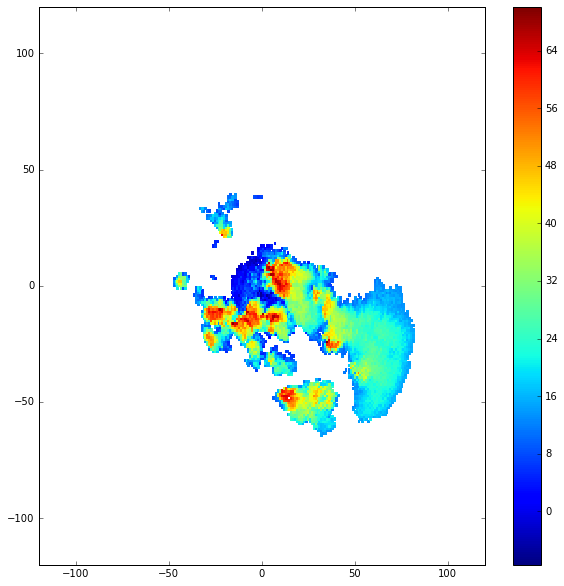

In [211]:
data=data.transpose()
aa=ma.array(data,mask=np.isnan(data))
plt.figure(figsize=(10,10))
plt.pcolormesh(X/1000,Y/1000,aa,shading='flat')
plt.axis([-120, 120, -120, 120])
plt.colorbar()
plt.show()
plt.close()


## CAPPI

In [274]:
elevs=np.unique(radar.elevation['data'])

rango=radar.range
X = np.linspace(-120000.10, 120000.10, num=240) # en metros
Y = np.linspace(-120000.10,120000.10, num=240) # en metros
Datos=np.ones([len(X),len(Y)])
H=9000 ### En metros
Re = 8495000 ###En metros aproximacion por ke
alt_radar = radar.altitude['data'][0]
rango=radar.range['data']
for i in range(len(X)):
    for j in range(len(Y)):
        x=X[i]
        y=Y[j]
        
        s=np.sqrt(x**2+y**2)
        p=(s**2)/(2*Re)
        alpha=s/Re
        w=H-alt_radar-p
        z=np.tan(alpha)*(Re+H+p)
        phi=np.arctan(w/z)*180/np.pi
        sr=np.sqrt(z**2+w**2) ###rango sobre el rayo
        r = abs(rango-sr).argmin()
        
        if s>rango[-1]:
            valor=np.nan
        
        else:
        
        ####Calculo del azimuth
            theta=np.arctan(x/y)*180/np.pi;
        
            if x>0 and y >0:
                theta = 360-theta
            elif y>0 and x<0: 
                theta = -theta
            elif y<0 and x<0:
                theta=180-theta
            else:
                theta=(180-theta)
        
        

            
        ### Calculo de angulo sobre elevacion
        
        
            ang_el2=elevs[abs(elevs-phi).argmin()]
            if ang_el2==elevs[-1]: ###Si me paso de la elevacion mas alta
                valor= np.nan
            
            else:
                if ang_el2>phi:
                    ang_el1=ang_el2     
                    ang_el2=elevs[abs(elevs-phi).argmin()-1]    
                else:
                    ang_el1=elevs[abs(elevs-phi).argmin()+1]
            
              
                num_el1 = np.where(elevs==ang_el1)[0][0] ###indexado desde cero
                num_el2 = num_el1-1
    
        
                if num_el2==-1:
                    valor=np.nan
           
                else:
            
                    d1=abs(ang_el1-phi)
                    d2=abs(ang_el2-phi)
                
                
                    az_s=radar.azimuth['data'][360*num_el1:360*(num_el1+1)]
                    th1=az_s[abs(az_s-(theta)).argmin()]             
                
                    az_s=radar.azimuth['data'][360*num_el2:360*(num_el2+1)]
                    th2=az_s[abs(az_s-(theta)).argmin()]
                
                    indice_th1=AzC[num_el1][int(th1)]
                    indice_th2=AzC[num_el2][int(th2)]
                    
                    G2=radar.fields['dBZ']['data'][indice_th2,r]
                    G1=radar.fields['dBZ']['data'][indice_th1,r]
                    w1=d2/(d1+d2)
                    w2=1-w1
                    valor = G1*w1+G2*w2
                
                    
       
        Datos[i,j]=valor
              

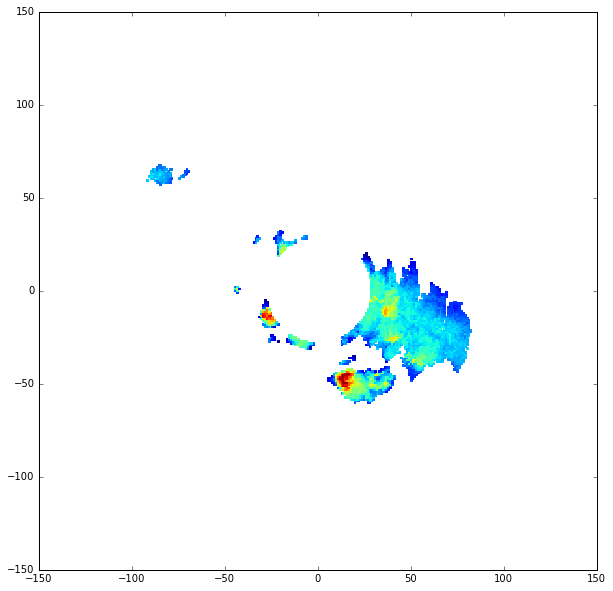

In [275]:
Datos=Datos.transpose()
Datos=np.fliplr(Datos)

a=ma.array(Datos,mask=np.isnan(Datos))
#a[np.where(Datos==1)]=ma.masked
plt.figure(figsize=(10,10))
plt.pcolor(X/1000,Y/1000,a)
#plt.colorbar()
plt.show()
plt.close()